# Apprentice Chef - Regression Model Development

> *by Jack Daoud, February 11th 2021*

# Setup

In [1]:
# Set up environment with libraries & data

##############################################################################
# Import libraries

import pandas as pd                     # data sceince essentials
import matplotlib.pyplot as plt         # essential graphical output
import seaborn as sns                   # enhanced visualizations
import numpy as np                      # mathematical essentials
from tqdm.notebook import tqdm          # progress bars
import time                             # time essentials

t0 = time.time()            # start time of script

# Set Pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

##############################################################################
# Import data

# Specify file name
file_data = './_data/Apprentice_Chef_Dataset.xlsx'

# Read file into Python
chefs = pd.read_excel(io     = file_data,
                      header = 0)

##############################################################################
# Fix data

# Rename LARGEST_ORDER_SIZE to AVG_MEALS_ORDERED
chefs.rename(columns={'LARGEST_ORDER_SIZE':'AVG_MEALS_ORDERED'}, inplace=True)

# Print dimensions of data
print(f"""
Size of Original Dataset
------------------------
Observations: {chefs.shape[0]}
Features:     {chefs.shape[1]}
""")


Size of Original Dataset
------------------------
Observations: 1946
Features:     28



# Feature Engineering

In [2]:
# Transformations (3) & Variable Derivations (6)

##############################################################################
# 3 Log transformations

# REVENUE
chefs['log_REVENUE'] = np.log10(chefs['REVENUE'])


# log_AVG_PREP_VID_TIME
chefs['log_AVG_PREP_VID_TIME'] = np.log10(chefs['AVG_PREP_VID_TIME'])


# log_AVG_TIME_PER_SITE_VISIT
chefs['log_AVG_TIME_PER_SITE_VISIT'] = np.log10(chefs['AVG_TIME_PER_SITE_VISIT'])


# log_CONTACTS_W_CUSTOMER_SERVICE
chefs['log_CONTACTS_W_CUSTOMER_SERVICE'] = np.log10(chefs['CONTACTS_W_CUSTOMER_SERVICE'])


##############################################################################
# 6 Derived Variables

# TOTAL_CANCELS (AGGREGATION)
chefs['TOTAL_CANCELS'] = chefs['CANCELLATIONS_BEFORE_NOON'] + chefs['CANCELLATIONS_AFTER_NOON']    
    

# TOTAL_MEALS_DELIVERED (SUBTRACTION)
chefs['TOTAL_MEALS_DELIVERED'] = chefs['TOTAL_MEALS_ORDERED'] - chefs['TOTAL_CANCELS']


# CONTACTS_PER_ORDER (RATIO)
chefs['CONTACTS_PER_ORDER'] = chefs['CONTACTS_W_CUSTOMER_SERVICE'] / chefs['TOTAL_MEALS_ORDERED']
        # consider log_CONTACTS_W_CUSTOMER_SERVICE


# VARIETY_OF_ORDERS (RATIO)
chefs['VARIETY_OF_ORDERS'] = chefs['TOTAL_MEALS_ORDERED'] / chefs['UNIQUE_MEALS_PURCH']


# LATE_MEAL_ORDER_RATIO
chefs['LATE_MEAL_ORDER_RATIO'] = chefs['LATE_DELIVERIES'] / chefs['TOTAL_MEALS_ORDERED']
    

# MEALS PER CLICK (RATIO)
chefs['MEALS_PER_CLICK'] = chefs['AVG_MEALS_ORDERED'] / chefs['AVG_CLICKS_PER_VISIT']

In [3]:
# Binary Variables (8)

# Basic Rule:
# At least 100 observations must be on both sides of the flag (1s and 0s)

# Calculate number of observations with 0s per variable
photos             = sum(chefs['TOTAL_PHOTOS_VIEWED'][:] == 0)       # TOTAL_PHOTOS_VIEWED
early_deliveries   = sum(chefs['EARLY_DELIVERIES'][:] == 0)          # EARLY_DELIVERIES
late_deliveries    = sum(chefs['LATE_DELIVERIES'][:] == 0)           # LATE_DELIVERIES
early_cancellation = sum(chefs['CANCELLATIONS_BEFORE_NOON'][:] == 0) # CANCELLATIONS_BEFORE_NOON
late_cancellation  = sum(chefs['CANCELLATIONS_AFTER_NOON'][:] == 0)  # CANCELLATIONS_AFTER_NOON
canceled           = sum(chefs['TOTAL_CANCELS'][:] == 0)             # TOTAL_CANCELS
subscribers        = sum(chefs['WEEKLY_PLAN'][:] == 0)               # WEEKLY_PLAN
learner            = sum(chefs['MASTER_CLASSES_ATTENDED'][:] == 0)   # MASTER_CLASSES_ATTENDED


# printing a table of the results
print(f"""
                 No\t\tYes
               ---------------------
Viewd Photos   | {photos}\t\t{len(chefs) - photos}
Early Delivery | {early_deliveries}\t\t{len(chefs) - early_deliveries}
Late Delivery  | {late_deliveries}\t\t{len(chefs) - late_deliveries}
Early Cancel   | {early_cancellation}\t\t{len(chefs) - early_cancellation}
Late Cancel    | {late_cancellation}\t\t{len(chefs) - late_cancellation}
Total Cancels  | {canceled}\t\t{len(chefs) - canceled}
Subscribers    | {subscribers}\t\t{len(chefs) - subscribers}
Learner        | {learner}\t\t{len(chefs) - learner}
""")

##############################################################################
# Engineer Features

# dummy variables
chefs['VIEWED_PHOTOS']      = 0
chefs['EARLY_DELIVERY']     = 0
chefs['LATE_DELIVERY']      = 0
chefs['EARLY_CANCELLATION'] = 0
chefs['LATE_CANCELLATION']  = 0
chefs['CANCELED']           = 0
chefs['SUBSCRIBER']         = 0
chefs['LEARNER']            = 0

for index, value in chefs.iterrows():

    # TOTAL_PHOTOS_VIEWED
    if chefs.loc[index, 'TOTAL_PHOTOS_VIEWED'] > 0:
        chefs.loc[index, 'VIEWED_PHOTOS'] = 1
        
        
    # EARLY_DELIVERIES
    if chefs.loc[index, 'EARLY_DELIVERIES'] > 0:
        chefs.loc[index, 'EARLY_DELIVERY'] = 1
        
        
    # LATE_DELIVERIES
    if chefs.loc[index, 'LATE_DELIVERIES'] > 0:
        chefs.loc[index, 'LATE_DELIVERY'] = 1
        
        
    # EARLY_CANCELLATION
    if chefs.loc[index, 'CANCELLATIONS_BEFORE_NOON'] > 0:
        chefs.loc[index, 'EARLY_CANCELLATION'] = 1
       
    
    # LATE_CANCELLATION
    if chefs.loc[index, 'CANCELLATIONS_AFTER_NOON'] > 0:
        chefs.loc[index, 'LATE_CANCELLATION'] = 1
        
        
    # TOTAL_CANCELS
    if chefs.loc[index, 'TOTAL_CANCELS'] > 0:
        chefs.loc[index, 'CANCELED'] = 1

        
    # WEEKLY_PLAN
    if chefs.loc[index, 'WEEKLY_PLAN'] > 0:
        chefs.loc[index, 'SUBSCRIBER'] = 1
        
        
    # MASTER_CLASSES_ATTENDED
    if chefs.loc[index, 'MASTER_CLASSES_ATTENDED'] > 0:
        chefs.loc[index, 'LEARNER'] = 1




                 No		Yes
               ---------------------
Viewd Photos   | 1140		806
Early Delivery | 1167		779
Late Delivery  | 319		1627
Early Cancel   | 667		1279
Late Cancel    | 1667		279
Total Cancels  | 572		1374
Subscribers    | 468		1478
Learner        | 932		1014



In [4]:
# LAST_NAME Binary Variable

"""
This is is a YES/NO variable for customers with a legitimate FAMILY_NAME.
Legitimate means customer's FAMILY_NAME is non-identical to the FIRST_NAME.

- A small portion of users didn't input a family name.
- Another portion inputted their family name identical to their first name.

We will group aforementioned portions into customers with NO LAST_NAME.

This variable assumes that FIRST_NAME and FAMILY_NAME shouldn't be identical.
Some may argue that some people have identical FIRST_NAME and FAMILY_NAME,
however, this is a rare occurance. 

This is based on the reasoning that people who only input first name in a lead
generation form might not be serious and not intend to buy anything (Chase, 2021).
"""

# Count the number of times a space appears in a customers NAME
chefs['LAST_NAME'] = chefs['NAME'].str.count(' ')

# Check if the customer has a last name and flag them
chefs.loc[chefs['LAST_NAME'] > 1, 'LAST_NAME'] = 1

##############################################################################
        
# Plot Number of Customers with missing family names

# Count number of customers with last names
last_names = chefs['LAST_NAME'].value_counts()

# Create plot
ax = last_names.plot(kind='bar', 
                      legend = True,
                      figsize = (8,6),
                      rot = 0,
                      colormap = "Paired")


# Annotate plot with values
for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 6),
                textcoords='offset points')

# Set plot aesthetics
ax.set_ylabel('# Customers',size = 14)
ax.set_xlabel('')
ax.set_title('Customers with Family Names', size = 14)
ax.set_xticklabels(labels = ['Has Family Name', 'No Family Name'])
ax.legend().remove()

# Display plot
#plt.show()
plt.close()

In [5]:
# MEAL_POLARITY Ordinal Variable

"""
This is a ordinal variable that classifies customer polarity based off
their MEDIAN_MEAL_RATING. 
- If the rating is greater than 3 (midpoint), then customer polarity is positive
- If the rating is less than 3, then customer polarity is negative
- If the rating equals 3, then customer polarity neutral

Positive = 1
Neutral  = 0
Negative = -1
"""

# Loop through each customer
for index, column in chefs.iterrows():
    
    # Check if the customer has a positive experience on average
    if chefs.loc[ index , 'MEDIAN_MEAL_RATING'] > 3:
        chefs.loc[ index , 'MEAL_POLARITY'] = 1
    elif chefs.loc[ index , 'MEDIAN_MEAL_RATING'] < 3:
        chefs.loc[ index , 'MEAL_POLARITY'] = -1
    else:
        chefs.loc[ index , 'MEAL_POLARITY'] = 0
        
        
# Change data type to integer
chefs.MEAL_POLARITY = chefs.MEAL_POLARITY.astype(int)

##############################################################################
# Plot Polarity by Customers

# Count number of churn per month
domains = chefs['MEAL_POLARITY'].value_counts()

# Create plot
ax = domains.plot(kind='bar', 
                  legend = True,
                  figsize = (8,6),
                  rot = 0,
                  colormap = "Paired")


# Annotate plot with values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 6),
                textcoords='offset points')

# Set plot aesthetics
ax.set_ylabel('# Customers',size = 14)
ax.set_xlabel('')
ax.set_title('Polartiy of Customers towards Meal Sets', size = 14)
ax.set_xticklabels(labels = ['Neutral', 'Negative', 'Positive'])
ax.legend().remove()
 
# Display plot
#plt.show()
plt.close()

In [6]:
# ABOVE_AVG_CONTACT_W_CS Binary Variable

"""
This is a binary variable that classifies whether or not a customer contacted
customer service more than the average customer.

If the number contacts a customer has with customer service is higher than
the average (7 contacts), then that customer will have a flag of 1.
"""

# Create complained variable and set it to 0
chefs['ABOVE_AVG_CONTACT_W_CS'] = 0

# Calculate average of contacts with customer_service
AVG_CONTACTS_W_CUSTOMER_SERVICE = chefs['CONTACTS_W_CUSTOMER_SERVICE'].mean()

# Loop through each customer
for index, column in chefs.iterrows():
    
    # Check if the customer has a positive experience on average
    if chefs.loc[ index , 'CONTACTS_W_CUSTOMER_SERVICE'] > AVG_CONTACTS_W_CUSTOMER_SERVICE:
        chefs.loc[ index , 'ABOVE_AVG_CONTACT_W_CS'] = 1
        
##############################################################################       
# Plot Number of Complaining Customers

# Count number of customers who complained
domains = chefs['ABOVE_AVG_CONTACT_W_CS'].value_counts()

# Create plot
ax = domains.plot(kind='bar', 
                  legend = True,
                  figsize = (8,6),
                  rot = 0,
                  colormap = "Paired")


# Annotate plot with values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 6),
                textcoords='offset points')

# Set plot aesthetics
ax.set_ylabel('# Customers',size = 14)
ax.set_xlabel('')
ax.set_title('Number of Customers with Above Avg Contact with Customer Service', size = 14)
ax.set_xticklabels(labels = ['Above Avg', "Avg & Below"])
ax.legend().remove()
 
# Display plot
#plt.show()
plt.close()

In [7]:
# GENDER Binary Variable

"""
1 denotes Male
0 denotes Female
"""


# Game of Thrones Names & Genders

# Source: https://www.kaggle.com/mylesoneill/game-of-thrones?select=character-predictions.csv

# Code for extraction:

# Import Game of Thrones character data
#genders = pd.read_csv('./_data/Game_of_Thrones_Characters.csv')

# Select only name & gender columns
#genders = genders[['name', 'male']]

# Rename columns to match Chefs DataFrame
#genders.columns = ['NAME', 'GENDER']

# Convert to lists for hardcoding
#names   = genders['NAME'].tolist()
#genders = genders['GENDER'].tolist()

# Hardcoded data
names = [
 'Viserys II Targaryen',
 'Walder Frey',
 'Addison Hill',
 'Aemma Arryn',
 'Sylva Santagar',
 'Tommen Baratheon',
 'Valarr Targaryen',
 'Viserys I Targaryen',
 'Wilbert',
 'Wilbert Osgrey',
 'Will',
 'Will (orphan)',
 'Will (squire)',
 'Will (Standfast)',
 'Will (Treb)',
 'Will Humble',
 'Willam',
 'Willem Wylde',
 'Willifer',
 'Willit',
 'Willis Wode',
 'Willis Fell',
 'Willow Heddle',
 'Willum',
 'Wolmer',
 'Willow Witch-eye',
 'Woth',
 'Wulfe',
 'Wyl the Whittler',
 'Wyl (guard)',
 'Wyl Waynwood',
 'Wun Weg Wun Dar Wun',
 'Wylla',
 'Wynafryd Manderly',
 'Xhondo',
 'Ygon Farwynd',
 'Yna',
 'Yohn Farwynd',
 'Yorkel',
 'Yorko Terys',
 'Yormwell',
 'Young Henly',
 'Ysilla',
 'Zarabelo',
 'Zei',
 'Zekko',
 'Zharaq zo Loraq',
 'Wenda',
 'Wex Pyke',
 'Timett',
 'Joffrey Baratheon',
 'Laenor Velaryon',
 'Leobald Tallhart',
 'Maegor I Targaryen',
 'Margaery Tyrell',
 'Naerys Targaryen',
 'Quence',
 'Quellon Botley',
 'Quellon Greyjoy',
 'Quentyn Blackwood',
 'Quenton Greyjoy',
 'Quhuru Mo',
 'Quickfinger',
 'Quill',
 'Quentin Tyrell',
 'Quort',
 'Qyle',
 'Rafe',
 'Racallio Ryndoon',
 'Ragnor Pyke',
 'Rainbow Knight',
 'Randa',
 'Rast',
 'Rawney',
 'Raymar Royce',
 'Raymond Nayland',
 'Raymund Tyrell',
 'Red Oarsman',
 'Red Lamb',
 'Redtusk',
 'Red Rolfe',
 'Redwyn',
 'Reynard Webber',
 'Reysen',
 'Rhaegel Targaryen',
 'Rhaena Targaryen (daughter of Daemon)',
 'Rhaena Targaryen (daughter of Aegon III)',
 'Rhaenys Targaryen',
 'Rhaenys Targaryen (daughter of Rhaegar)',
 'Rhialta Vance',
 'Rhaenys Targaryen (daughter of Aemon)',
 'Rhonda Rowan',
 'Richard Farrow',
 'Richard Lonmouth',
 'Rigney',
 'Rob',
 'Rickard Tyrell',
 'Robb Reyne',
 'Robert Ashford',
 'Robert Brax (son of Flement)',
 'Robert Paege',
 'Robb Stark',
 'Robin',
 'Robert Frey (son of Raymund)',
 'Robin Greyjoy',
 'Robin Hollard',
 'Rodrik Freeborn',
 'Roelle',
 'Rodrik Stark (son of Beron)',
 'Roger of Pennytree',
 'Roggo',
 'Roger Ryswell',
 'Rolder',
 'Roland Crakehall (Kingsguard)',
 'Rolfe',
 'Rolland Darklyn',
 'Rollam Westerling',
 'Romny Weaver',
 'Ronald Storm',
 'Ronnel Stout',
 'Ronnel Harclay',
 'Roone',
 'Roone (maester)',
 'Roryn Drumm',
 'Roose Ryswell',
 'Rosamund Lannister',
 'Rosey',
 'Rowan',
 'Rudge',
 'Runciter',
 'Rupert Crabb',
 'Rus',
 'Rusty Flowers',
 'Ryam',
 'Ryk',
 'Ryles',
 'Rymolf',
 "S'vrone",
 'Saathos',
 "Sailor's Wife",
 'Sallor',
 'Salloreon',
 'Sam Stoops',
 'Samwell Spicer',
 'Sargon Botley',
 'Scarb',
 'Sawwood',
 'Sedgekins',
 'Sefton Staunton',
 'Serra',
 'Sharna',
 'Shella',
 'Sherrit',
 'Shortear',
 'Shyra',
 'Sigfry Stonetree',
 'Sigrin',
 'Simon Leygood',
 'Sky Blue Su',
 'Skinner',
 'Skittrick',
 'Skyte',
 'Sloey',
 'Spare Boot',
 'Softfoot',
 'Spotted Pate of Maidenpool',
 'Squint',
 'Squirrel',
 'Steffarion Sparr',
 'Stafford Lannister',
 'Steffon Fossoway',
 'Steffon Hollard',
 'Stannis Baratheon',
 'Steffon Varner',
 'Stone Thumbs',
 'Stonehand',
 'Sybassion',
 'Sylas',
 'Symon Stripeback',
 'Symond Botley',
 'Tagganaro',
 'Tal Toraq',
 'Talea',
 'Talla Tarly',
 'Tansy',
 'Tansy (orphan)',
 'Tarber',
 'Terrance Lynderly',
 'Terro',
 'Theo Frey',
 'Theobald',
 'Thistle',
 'Theon Stark',
 'Thormor Ironmaker',
 'Tim Stone',
 'Timon',
 'Timett (father)',
 'Timoth',
 'Tobbot',
 'Toefinger',
 'Todric',
 'Tom Costayne',
 'TomToo',
 'Tommard Heddle',
 'Toregg',
 'Torrek',
 'Tothmure',
 'Torrhen Stark',
 'Tregar',
 'Tregar Ormollen',
 'Tristan Ryger',
 'Tristifer V Mudd',
 'Tristimun',
 'Tristifer IV Mudd',
 'Tuffleberry',
 'Tumberjon',
 'Tumco Lho',
 'Turnip',
 'Turquin',
 'Tybero Istarion',
 'Tymor',
 'Ulf the Ill',
 'Tywin Frey (son of Raymund)',
 'Uller',
 'Umar',
 'Umfred',
 'Umma',
 'Urreg',
 'Urek Ironmaker',
 'Urrathon',
 'Urzen',
 'Urron Greyiron',
 'Urrigon Greyjoy',
 'Uthor Underleaf',
 'Utt',
 'Vaellyn',
 'Varly',
 'Veiled Lady',
 'Vickon Botley',
 'Violet',
 'Victor Tyrell',
 'Walda Frey (daughter of Lothar)',
 'Walda Frey (daughter of Edwyn)',
 'Walda Frey (daughter of Rhaegar)',
 'Walda Frey (daughter of Walton)',
 'Walda Frey (daughter of Merrett)',
 'Walda Rivers (daughter of Aemon)',
 'Walder Frey (son of Jammos)',
 'Walder Frey (son of Emmon)',
 'Walder Frey (son of Ryman)',
 'Walder Frey (son of Merrett)',
 'Wallen',
 'Walton',
 'Walys Flowers',
 'Wat (Barleycorn)',
 'Blue Bard',
 'Wat (orphan)',
 'Wat (sailor)',
 'Wat (Standfast)',
 'Wat (Wet)',
 'Wate',
 'Watt',
 'Wayn (guard)',
 'Weasel',
 'Wendell Webber',
 'Wendello Qar Deeth',
 'Werlag',
 'Rafford',
 'Jhogo',
 'Sour Alyn',
 'Tobho Mott',
 'Zollo',
 'Tanda Stokeworth',
 'Samwell Tarly',
 'Abelar Hightower',
 'Addam Frey',
 'Addam',
 'Addam Osgrey',
 'Aegon Frey (son of Aenys)',
 'Aegon Frey (son of Stevron)',
 'Aegon I Targaryen',
 'Aegon II Targaryen',
 'Aegon IV Targaryen',
 'Aegon Targaryen (son of Baelon)',
 'Aegon III Targaryen',
 'Aegon Targaryen (son of Jaehaerys I)',
 'Aegon Targaryen (son of Aenys I)',
 'Aegon Targaryen (son of Rhaegar)',
 'Aemon Costayne',
 'Aenys I Targaryen',
 'Aethan',
 'Aethelmure',
 'Aggar',
 'Agrivane',
 'Aerys I Targaryen',
 'Alaric of Eysen',
 'Aerys II Targaryen',
 'Alebelly',
 'Alequo Adarys',
 'Alester Oakheart',
 'Alia',
 'All-for-Joffrey',
 'Allaquo',
 'Allyria Dayne',
 'Alicent Hightower',
 'Alyce',
 'Alvyn Sharp',
 'Alyn Hunt',
 'Alys Arryn',
 'Alysanne Bracken',
 'Alyn Velaryon',
 'Alysanne Osgrey',
 'Alyssa Arryn',
 'Alysanne Hightower',
 'Amabel',
 'Ambrode',
 'Andrey Dalt',
 'Andrey Charlton',
 'Argrave the Defiant',
 'Armen',
 'Arneld',
 'Arnell',
 'Arrec Durrandon',
 'Arron',
 'Arryk (guard)',
 'Arron Qorgyle',
 'Arson',
 'Aubrey Ambrose',
 'Ayrmidon',
 'Baelon Targaryen (son of Viserys I)',
 'Baelon Targaryen (son of Aerys)',
 'Balon Botley',
 'Baelor Targaryen (son of Daeron II)',
 'Bandy',
 'Bannen',
 'Barre',
 'Barbara Bracken',
 'Barth (brewer)',
 'Bass',
 'Bearded Ben',
 'Becca',
 'Beck',
 'Belandra',
 'Beldecar',
 'Belis',
 'Bellonara Otherys',
 'Bella',
 'Ben',
 'Ben Blackthumb',
 'Ben Bones',
 'Ben Bushy',
 'Benedict',
 'Benjen Stark (Bitter)',
 'Benjen Stark (Sweet)',
 'Bennet',
 'Bennis',
 'Beqqo',
 'Bennarion Botley',
 'Beron Blacktyde',
 'Bertram Beesbury',
 'Bessa',
 'Bessa (Winterfell)',
 'Bess Bracken',
 'Bethany (Blushing Bethany)',
 'Bethany Fair-Fingers',
 'Bharbo',
 'Big Boil',
 'Blind Doss',
 'Blane',
 'Bodger',
 'Borcas',
 'Bors',
 'Borroq',
 'Boy',
 'Brandon Stark (Bad)',
 'Brandon Stark (Burner)',
 'Brandon Stark (the daughterless)',
 'Brandon Stark (son of Cregan)',
 'Brandon Stark (Shipwright)',
 'Brea',
 'Brella',
 'Brenett',
 'Briar',
 'Brogg',
 'Brusco',
 'Brown Bernarr',
 'Bryan of Oldtown',
 'Bryen',
 'Buford Bulwer',
 'Bump',
 'Buu',
 'Byan Votyris',
 'Byam Flint',
 'Byren Flowers',
 'Byron',
 'Cadwyl',
 'Lord Cafferen',
 'Calon',
 'Cadwyn',
 'Canker Jeyne',
 'Carellen Smallwood',
 'Cass',
 'Carrot',
 'Castos',
 'Cedra',
 'Catelyn Bracken',
 'Cedric Payne',
 'Cedrik Storm',
 'Cerrick',
 'Cetheres',
 'Catelyn Stark',
 'Cheyk',
 'Chiggen',
 'Clarence Crabb',
 'Clarence Charlton',
 'Clarence Crabb (Short)',
 'Clement',
 'Cleyton Caswell',
 'Clifford Conklyn',
 'Colen of Greenpools',
 'Collio Quaynis',
 'Conn',
 'Coratt',
 'Cosgrove',
 'Cossomo',
 'Courtenay Greenhill',
 'Cregan Karstark',
 'Cutjack',
 'Dacks',
 'Daella Targaryen (daughter of Jaehaerys I)',
 'Daella Targaryen (daughter of Maekar I)',
 'Daenerys Targaryen (daughter of Aegon IV)',
 'Daeron I Targaryen',
 'Daena Targaryen',
 'Daeryssa',
 'Daeron Targaryen (son of Viserys I)',
 'Dagon Ironmaker',
 'Daeron Targaryen (son of Maekar I)',
 'Daeron II Targaryen',
 'Dake',
 'Dale Drumm',
 'Dalla (Dragonstone)',
 'Damon Lannister (lord)',
 'Dan',
 'Damon Lannister (son of Jason)',
 'Darla Deddings',
 'Danos Slynt',
 'Daughter of the Dusk',
 'Del',
 'Denestan',
 'Denyo Terys',
 'Dennis Plumm',
 'Denys Drumm',
 'Denys Redwyne',
 'Denyse Hightower',
 'Dhazzar',
 'Dick Follard',
 'Dickon Manwoody',
 'Dobber',
 'Donnel Drumm',
 'Donel Greyjoy',
 'Donella Hornwood',
 'Donnel Hill',
 'Donnis',
 'Donyse',
 'Dorcas',
 'Dornish Dilly',
 'Dorren Stark',
 'Draqaz',
 'Drennan',
 'Dudley',
 'Dryn',
 'Dunaver',
 'Durran',
 'Dyah',
 'Dykk Harlaw',
 'Easy',
 'Duncan Targaryen',
 'Edgerran Oakheart',
 'Eden Risley',
 'Edmund Ambrose',
 'Edwyn Osgrey',
 'Eggon',
 'Eglantine',
 'Egon Emeros',
 'Eldiss',
 'Eldred Codd',
 'Elaena Targaryen',
 'Elys Westerling',
 'Elyas Willum',
 'Elza',
 'Emma',
 'Elys Waynwood',
 'Emrick',
 'Endehar',
 'Emphyria Vance',
 'Enger',
 'Erik Ironmaker',
 'Erreck',
 'Erreg',
 'Errok',
 'Erryk (guard)',
 'Esgred',
 'Eustace (Braavos)',
 'Eustace (Dance of the Dragons)',
 'Ezzara',
 'Euron Greyjoy',
 'Ezzelyno',
 'Fern',
 'Ferny',
 'Ferret',
 'Fogo',
 'Fornio',
 'Fralegg',
 'Frenya',
 'Frynne',
 'Gage',
 'Galladon of Morne',
 'Gallard',
 'Galt',
 'Galtry the Green',
 'Galyeon of Cuy',
 'Gareth the Grey',
 'Garigus',
 'Garizon',
 'Gariss',
 'Garrett Paege',
 'Garth XII Gardener',
 'Garth of Oldtown',
 'Gascoyne',
 'Gavin',
 'Gelmarr',
 'Gerren',
 'Gerold Lannister',
 'Ghael',
 'Gillam',
 'Gladden Wylde',
 'Glendon Flowers',
 'Goady',
 'Godwyn',
 'Gormond Drumm',
 'Gowen Baratheon',
 'Grance Morrigen',
 'Grazdan',
 'Grazdan zo Galare',
 'Green Gergen',
 'Great Walrus',
 'Gretchel',
 'Grey King',
 'Griffin King',
 'Grigg',
 'Grisel',
 'Grisella',
 'Gulian',
 'Gulian Qorgyle',
 'Gurn',
 'Guyne',
 'Gwayne Corbray',
 'Gwayne Gaunt',
 'Gwin Goodbrother',
 'Gyles',
 'Gyleno Dothare',
 'Gyles Farwynd',
 'Gwynesse Harlaw',
 'Gyles Grafton',
 'Gyloro Dothare',
 'Gyles III Gardener',
 'Gynir',
 'Haggon',
 'Gysella Goodbrother',
 'Hali',
 'Haldon',
 'Harbert Paege',
 'Hamish the Harper',
 'Halys Hornwood',
 'Harghaz',
 "Hareth (Mole's Town)",
 'Harlan Grandison',
 'Harle the Handsome',
 'Harle the Huntsman',
 'Harlon Botley',
 'Harmund Sharp',
 'Harlon Greyjoy',
 'Harodon',
 'Harra',
 'Harrag Sharp',
 'Harrag Hoare',
 'Harren Half-Hoare',
 'Harren Botley',
 'Harrold Osgrey',
 'Harry Sawyer',
 'Harsley',
 'Harwyn Hoare',
 'Hayhead',
 'Hazrak zo Loraq',
 'Harwyn Plumm',
 'Helicent Uffering',
 'Helliweg',
 'Helly',
 'Helya',
 'Henk',
 'Henly (House Ashford)',
 'Herbert Bolling',
 'Hendry Bracken',
 'Heward',
 'Hibald',
 'Hilmar Drumm',
 'Hod',
 'Hoke',
 'Holger',
 'Hop-Robin',
 'Hugh Beesbury',
 'Humfrey Clifton',
 'Hunnimore',
 'Husband',
 'Illifer',
 'Ironbelly',
 'Jaehaerys Targaryen (son of Aegon II)',
 'Jaehaera Targaryen',
 'Jaggot',
 'Jaehaerys II Targaryen',
 'Jaime Frey',
 'Jaehaerys I Targaryen',
 'Jate',
 'Jate Blackberry',
 'Jasper Waynwood',
 'Jayde',
 'Jeffory Norcross',
 'Jeffory Mallister',
 'Jayne Bracken',
 'Squinty Jeyne',
 'Jeyne Fossoway',
 'Jeyne Heddle',
 'Jeyne Swann',
 'Jeyne Westerling (wife of Maegor I)',
 'Jeyne Waters',
 'Jeyne Westerling',
 'Jocelyn Swyft',
 'Jodge',
 'Joanna Swyft',
 'Joanna Lannister',
 'Johanna Swann',
 'Jommo',
 'Jommy',
 'Jon Cupps',
 'Jon Heddle',
 'Jon Hollard',
 'Jon Penny',
 'Jon Penrose',
 'Jon Pox',
 'Jon Vance',
 'Jon Umber (Smalljon)',
 'Jon Umber (Greatjon)',
 'Jon Waters',
 'Jorquen',
 'Jorgen',
 'Joseran',
 'Joseth',
 'Joseth Mallister',
 'Joss',
 'Joss the Gloom',
 'Joth Quickbow',
 'Josua Willum',
 'Jurne',
 'Jothos Slynt',
 'Jyck',
 'Jyzene',
 'Kegs',
 'Kella',
 'Kemmett Pyke',
 'Kenned',
 'Ketter',
 'Kirby Pimm',
 'Kojja Mo',
 'Kirth Vance',
 'Koss',
 'Kromm',
 'Kurz',
 'Kyle',
 'Kyle (brotherhood)',
 'Kyle Royce',
 'Kyleg',
 'Kym',
 'Lamprey',
 'Lancel V Lannister',
 'Lanna',
 'Lanna (Happy Port)',
 'Larraq',
 'Layna',
 'Lem',
 'Leana Frey',
 'Lennocks',
 'Lem (Standfast)',
 'Lenn',
 'Lenyl',
 'Lenwood Tawney',
 'Leo Tyrell (Longthorn)',
 'Leona Tyrell',
 'Leo Tyrell (son of Victor)',
 'Lester',
 'Lew (guard)',
 'Lewis Lanster',
 'Lewys Piper',
 'Leyla Hightower',
 'Lia Serry',
 'Liane Vance',
 'Lister',
 'Long Lew',
 'Lorcas',
 'Lorent Lorch',
 'Lorimer',
 'Lorren',
 'Lothar',
 'Lorent Tyrell',
 'Lotho Lornel',
 'Lucan',
 'Lucamore Strong',
 'Lucantine Woodwright',
 'Lucas Nayland',
 'Lucas Roote',
 'Lucifer Hardy',
 'Luco Prestayn',
 'Lucimore Botley',
 'Lucos',
 'Luke of Longtown',
 'Lucas Tyrell',
 'Lum',
 'Luton',
 'Luthor Tyrell (son of Moryn)',
 'Luthor Tyrell (son of Theodore)',
 'Lymond Mallister',
 'Lync',
 'Lyonel (knight)',
 'Lyonel Bentley',
 'Lyonel Tyrell (lord)',
 'Lysa Meadows',
 'Lyonel Tyrell (son of Leo)',
 'Maddy',
 'Maerie (Goodwife)',
 'Maerie (Whore)',
 'Maggy',
 'Malcolm',
 'Malleon',
 'Malliard',
 'Mallor (Knight)',
 'Mallor',
 'Manfred Dondarrion',
 'Manfred Lothston',
 'Manfred Swann',
 'Manfryd Lothston',
 'Manfryd Yew',
 'Marei',
 'Marghaz zo Loraq',
 'Maris',
 'Marq Grafton',
 'Martyn Mullendore',
 'Maslyn',
 'Mathos Mallarawan',
 'Matrice',
 'Matt',
 'Maynard',
 'Maynard Plumm',
 'Mazdhan zo Loraq',
 'Mebble',
 'Meha',
 'Mela',
 'Meizo Mahr',
 'Melaquin',
 'Medwick Tyrell',
 'Meliana',
 'Melicent',
 'Mellei',
 'Melly',
 'Mellos',
 'Meralyn',
 'Merling Queen',
 'Mero',
 'Merrell Florent',
 'Michael Mertyns',
 'Miklaz',
 'Mollander',
 'Mollos',
 'Moonshadow',
 'Moreo Tumitis',
 'Morgarth',
 'Moro',
 'Morra',
 'Morrec',
 'Mors Manwoody',
 'Mortimer Boggs',
 'Mors Martell (brother of Doran)',
 'Mother Mole',
 'Mudge (brotherhood)',
 'Mudge (miller)',
 'Mudge (swineherd)',
 'Munciter',
 'Mully',
 'Murch',
 'Murch (Winterfell)',
 'Myles (squire)',
 'Myrtle',
 'Nage',
 'Nail',
 'Narbert',
 'Narbo',
 'Nan',
 'Ned (ferryman)',
 'Nella',
 'Ned Woods',
 'Nissa Nissa',
 'Nightingale',
 'Nolla',
 'Norjen',
 'Norren',
 'Nymos',
 'Normund Tyrell',
 'Ocley',
 'Ogo',
 'Old Crackbones',
 'Old Grey Gull',
 'Old Tattersalt',
 'Old Henly',
 'Olyvar Oakheart',
 'Olene Tyrell',
 'Orbelo',
 'Orivel',
 'Orell',
 'Ormond (knight)',
 'Ormond Osgrey',
 'Ormond Westerling',
 'Oro Tendyris',
 'Ormund Wylde',
 'Osmynd',
 'Ossy',
 'Oswyn',
 'Othor',
 'Otter Gimpknee',
 'Ottomore',
 'Owen (brother of Meribald)',
 'Owen',
 'Owen Inchfield',
 'Palla',
 'Pate (Old)',
 'Pate (Mory)',
 'Pate (Lancewood)',
 'Pate (Pinchbottom)',
 "Pate (Night's Watch)",
 "Pate (Shermer's Grove)",
 'Pate (Standfast)',
 'Penny Jenny',
 'Penny',
 'Perros Blackmont',
 'Perwyn Osgrey',
 'Peter Plumm',
 'Plummer',
 'Poetess',
 'Pollitor',
 'Porridge',
 'Porther',
 'Portifer Woodwright',
 'Poul Pemford',
 'Poxy Tym',
 'Praed',
 'Puckens',
 'Pudding',
 'Puddingfoot',
 'Qalen',
 'Qarl the Thrall',
 'Qarl Kenning',
 'Qarl Correy',
 'Qarl Shepherd',
 'Qarl Quickaxe',
 'Qos',
 'Quellon Humble',
 'Quaro',
 'Aelinor Penrose',
 'Aemon Estermont',
 'Aemon Rivers',
 'Aglantine',
 'Aladale Wynch',
 'Albett',
 'Albar Royce',
 'Alesander Staedmon',
 'Alekyne Florent',
 'Alesander Frey',
 'Alester Norcross',
 'Allard Seaworth',
 'Allar Deem',
 'Alla Tyrell',
 'Alyn Cockshaw',
 'Alyce Graceford',
 'Alyn Connington',
 'Alyn Ambrose',
 'Alyn Estermont',
 'Alyn Stackspear',
 'Alyn Frey',
 'Alyn Haigh',
 'Alysanne Bulwer',
 'Alysanne Lefford',
 'Alys Frey',
 'Alyssa Blackwood',
 'Alyx Frey',
 'Amarei Crakehall',
 'Ambrose Butterwell',
 'Andar Royce',
 'Andros Brax',
 'Antario Jast',
 'Andrew Estermont',
 'Annara Farring',
 'Ardrian Celtigar',
 'Anya Waynwood',
 'Androw Frey',
 'Armond Caswell',
 'Arthur Ambrose',
 'Arthor Karstark',
 'Arwyn Frey',
 'Artos Stark',
 'Arwood Frey',
 'Lord Ashford',
 'Azzak',
 'Baelor Hightower',
 'Balman Byrch',
 'Barth',
 'Bayard Norcross',
 'Bedwyck',
 'Barthogan Stark',
 'Bellena Hawick',
 'Benedar Belmore',
 'Benedict Broom',
 'Bennard Brune',
 'Benfrey Frey',
 'Beren Tallhart',
 'Berena Hornwood',
 'Beth Cassel',
 'Beron Stark',
 'Bhakaz zo Loraq',
 'Bethany Redwyne',
 'Bethany Rosby',
 'Black Bernarr',
 'Betharios of Braavos',
 'Boremund Harlaw',
 'Bradamar Frey',
 'Branston Cuy',
 'Brandon Tallhart',
 'Bryan Fossoway',
 'Bryan Frey',
 'Bryen Farring',
 'Bryen Caron',
 'Burton Crakehall',
 'Craghas Drahar',
 'Carolei Waynwood',
 'Lord Caswell',
 'Cayn',
 'Cerenna Lannister',
 'Cersei Frey',
 'Chayle',
 'Clarent Crakehall',
 'Clement Crabb',
 'Clement Piper',
 'Cley Cerwyn',
 'Clubfoot Karl',
 'Conwy',
 'Colin Florent',
 'Colmar Frey',
 'Corliss Penny',
 'Creighton Redfort',
 'Cuger',
 'Cregan Stark',
 'Cyrenna Swann',
 'Cynthea Frey',
 'Daegon Shepherd',
 'Daeron Vaith',
 'Dafyn Vance',
 'Dagon Greyjoy',
 'Dalbridge',
 'Damon Paege',
 'Damon Shett',
 'Damon Vypren',
 'Dancy',
 'Dareon',
 'Darlessa Marbrand',
 'Daryn Hornwood',
 'Danwell Frey',
 'Deana Hardyng',
 'Delena Florent',
 'Della Frey',
 'Delp',
 'Delonne Allyrion',
 'Denys Darklyn',
 'Denys Arryn',
 'Dermot',
 'Desmond',
 'Desmond Redwyne',
 'Deziel Dalt',
 'Dickon Tarly',
 'Dickon Frey',
 'Dirk',
 'Dolf',
 'Donnel Haigh',
 'Donnel of Duskendale',
 'Donnel Locke',
 'Donnel Waynwood',
 'Donnor Stark',
 'Dormund',
 'Duram Bar Emmon',
 'Ebben',
 'Edderion Stark',
 'Edmyn Tully',
 'Eddara Tallhart',
 'Edrick Stark',
 'Edwyd Fossoway',
 'Edwyn Stark',
 'Edwyle Stark',
 'Elder Brother',
 'Elbert Arryn',
 'Eleanor Mooton',
 'Ellery Vance',
 'Elron',
 'Elinor Tyrell',
 'Elmar Frey',
 'Elwood',
 'Elwood Meadows',
 'Elyana Vypren',
 'Elyn Norridge',
 'Emberlei Frey',
 'Endrew Tarth',
 'Eroeh',
 'Eon Hunter',
 'Ermesande Hayford',
 'Erena Glover',
 'Erren Florent',
 'Eustace Brune',
 'Eustace Hunter',
 'Eyron Stark',
 'Ferrego Antaryon',
 'Forley Prester',
 'Franklyn Fowler',
 'Flement Brax',
 'Frenken',
 'Franklyn Frey',
 'Gareth Clifton',
 'Garrison Prester',
 'Garth of Greenaway',
 'Garrett Flowers',
 'Garse Goodbrook',
 'Garse Flowers',
 'Garth Greenfield',
 'Garth Greyfeather',
 'Gawen Swann',
 'Gawen Glover',
 'Gawen Wylde',
 'Garth Tyrell',
 'Gendel',
 'Gawen Westerling',
 'Gerald Gower',
 'Gerold Grafton',
 'Gerardys',
 'Gilbert Farring',
 'Glendon Hewett',
 'Gilwood Hunter',
 'Godric Borrell',
 'Goodwin',
 'Gormon Peake',
 'Gorne',
 'Gormon Tyrell',
 'Grazdan mo Eraz',
 'Grazdan mo Ullhor',
 'Grazdar zo Galare',
 'Grubbs',
 'Gueren',
 'Guncer Sunglass',
 'Gulian Swann',
 'Guthor Grimm',
 'Gunthor Hightower',
 'Gyldayn',
 'Gwayne Hightower',
 'Hairy Hal',
 'Hake',
 'Halder',
 'Hallis Mollen',
 'Halmon Paege',
 'Harbert',
 'Harlan Hunter',
 'Harlen Tyrell',
 'Harmond Umber',
 'Harmune',
 'Harrold Westerling',
 'Harwood Fell',
 'Harwin Strong',
 'Harwood Stout',
 'Harys Haigh',
 'Helman Tallhart',
 'Lord Commander Hoare',
 'Hobber Redwyne',
 'Hoarfrost Umber',
 'Hosman Norcross',
 'Hoster Frey',
 'Horas Redwyne',
 'Hubard Rambton',
 'Horton Redfort',
 'Hotho Harlaw',
 'Hugo Wull',
 'Hugor of the Hill',
 'Hugo Vance',
 'Hullen',
 'Humfrey Beesbury',
 'Humfrey Hardyng',
 'Humfrey Swyft',
 'Humfrey Wagstaff',
 'Igon Vyrwel',
 'Jacks',
 'Janei Lannister',
 'Jammos Frey',
 'Janna Tyrell',
 'Jaremy Rykker',
 'Jarl',
 'Jason Lannister',
 'Jasper Arryn',
 'Jasper Redfort',
 'Jeren',
 'Jeyne Arryn',
 'Jeyne Beesbury',
 'Jeyne Darry',
 'Jeyne Goodbrook',
 'Jeyne Rivers',
 'Jeyne Lydden',
 'Joffrey Lonmouth',
 'Joffrey Caswell',
 'Jon Bettley',
 'Jon Brax',
 'Jon Lynderly',
 'Jon Myre',
 'Jon Redfort',
 'Jon Wylde',
 'Jonos Stark',
 'Jonos Frey',
 'Jonnel Stark',
 'Joramun',
 'Jorah Stark',
 'Jonothor Darry',
 'Jorelle Mormont',
 'Jyana',
 'Joy Hill',
 'Jyanna Frey',
 'Kaeth',
 'Jynessa Blackmont',
 'Karlon Stark',
 'Kedge Whiteye',
 'Kennos of Kayce',
 'Kezmya',
 'Kyra',
 'Kyra Frey',
 'Lambert Turnberry',
 'Lark',
 'Larence Snow',
 'Larra Blackmont',
 'Lanna Lannister',
 'Leathers',
 'Left Hand Lew',
 'Leo Lefford',
 'Leo Blackbar',
 'Leona Woolfield',
 'Leonette Fossoway',
 'Leonella Lefford',
 'Lester Morrigen',
 'Lewys the Fishwife',
 'Lewys Lydden',
 'Leslyn Haigh',
 'Lomas Estermont',
 'Lorent Marbrand',
 'Loreza Sand',
 'Lothar Mallery',
 'Lucas Corbray',
 'Lucas Codd',
 'Luceon Frey',
 'Lucias Vypren',
 'Lucos Chyttering',
 'Lucion Lannister',
 'Luthor Tyrell',
 'Lyanna Mormont',
 'Lyessa Flint',
 'Lyman Beesbury',
 'Lymond Goodbrook',
 'Lyman Darry',
 'Lymond Lychester',
 'Lymond Vikary',
 'Lyonel Selmy',
 'Aggo',
 'Alys Karstark',
 'Cleos Frey',
 'Dontos Hollard',
 'Craster',
 'Dale Seaworth',
 'Denys Mallister',
 'Edric Storm',
 'Hosteen Frey',
 'Lyonel Corbray',
 'Lyonel Frey',
 'Lyonel Strong',
 'Lythene Frey',
 'Lyra Mormont',
 'Maegelle Frey',
 'Mallador Locke',
 'Malwyn Frey',
 'Manfrey Martell',
 'Margot Lannister',
 'Maric Seaworth',
 'Marianne Vance',
 'Mariya Darry',
 'Marissa Frey',
 'Maron Martell',
 'Maron Volmark',
 'Marq Rankenfell',
 'Marsella Waynwood',
 'Matarys Targaryen',
 'Martyn Rivers',
 'Martyn Lannister',
 'Marwyn Belmore',
 'Mathis Frey',
 'Matthar',
 'Mawney',
 'Medgar Tully',
 'Medger Cerwyn',
 'Megga Tyrell',
 'Meldred Merlyn',
 'Melesa Crakehall',
 'Melara Crane',
 'Melessa Florent',
 'Mellara Rivers',
 'Melwyn Sarsfield',
 'Melwys Rivers',
 'Meredyth Crane',
 'Merianne Frey',
 'Merlon Crakehall',
 'Mezzara',
 'Mina Tyrell',
 'Moelle',
 'Monterys Velaryon',
 'Moredo Prestayn',
 'Monford Velaryon',
 'Moribald Chester',
 'Morton Waynwood',
 'Morya Frey',
 'Mullin',
 'Moryn Tyrell',
 'Munda',
 'Muttering Bill',
 'Mushroom',
 'Murmison',
 'Mylenda Caron',
 'Myles Smallwood',
 'Myles Mooton',
 'Myria Jordayne',
 'Myles Manwoody',
 'Mysaria',
 'Myrielle Lannister',
 'Noho Dimittis',
 'Norne Goodbrother',
 'Norbert Vance',
 'Nymella Toland',
 'Nysterica',
 'Ollidor',
 'Ollo Lophand',
 'Olyvar Frey',
 'Omer Blackberry',
 'Olymer Tyrell',
 'Ondrew Locke',
 'Orbert Caswell',
 'Ordello',
 'Omer Florent',
 'Orland of Oldtown',
 'Ormond Yronwood',
 'Orphan Oss',
 'Osbert Serry',
 'Osmund Frey',
 'Oswell Kettleblack',
 'Ossifer Plumm',
 'Otho Bracken',
 'Ottyn Wythers',
 'Owen Norrey',
 'Pate of the Blue Fork',
 'Patrek Mallister',
 'Patrek Vance',
 'Perriane Frey',
 'Perra Frey',
 'Perwyn Frey',
 'Philip Foote',
 'Philip Plumm',
 'Pono',
 'Qarro Volentin',
 'Qarlton Chelsted',
 'Lord Commander Qorgyle',
 'Quent',
 'Quenten Banefort',
 'Quenton Hightower',
 'Quentyn Ball',
 'Quentyn Qorgyle',
 'Quincy Cox',
 'Ragwyle',
 'Ralf Kenning',
 'Raymun Redbeard',
 'Raynard',
 'Raynald Westerling',
 'Red Alyn of the Rosewood',
 'Raynard Ruttiger',
 'Raymund Frey',
 'Regenard Estren',
 'Renly Norcross',
 'Renfred Rykker',
 'Rhea Royce',
 'Rennifer Longwaters',
 'Rhea Florent',
 'Rhogoro',
 'Rickard Ryswell',
 'Rickard Thorne',
 'Rickard Wylde',
 'Robert Frey',
 'Robert Flowers',
 'Robert Brax',
 'Robin Hill',
 'Robin Flint',
 'Robin Moreland',
 'Robin Ryger',
 'Rodrik Flint',
 'Rodrik Stark',
 'Rodrik Ryswell',
 'Roger Hogg',
 'Rodwell Stark',
 'Rolland Longthorpe',
 'Rolland Uffering',
 'Ronel Rivers',
 'Ronald Connington',
 'Ronald Vance',
 'Roro Uhoris',
 'Royce Coldwater',
 'Rufus Leek',
 'Rugen',
 'Runcel Hightower',
 'Rupert Brax',
 'Rycherd Crane',
 'Ryam Redwyne',
 'Ryam Florent',
 'Ryger Rivers',
 'Ryella Frey',
 'Ryella Royce',
 'Rylene Florent',
 'Ryon Allyrion',
 'Saera Targaryen',
 'Sallei Paege',
 'Sandor Frey',
 'Sarya Whent',
 'Sarra Frey',
 'Sawane Botley',
 'Scolera',
 'Sebaston Farman',
 'Selwyn Tarth',
 'Selmond Stackspear',
 'Serala',
 'Serwyn of the Mirror Shield',
 'Serra Frey',
 'Shella Whent',
 'Shierle Swyft',
 'Shiera Crakehall',
 'Shirei Frey',
 'Simon Staunton',
 'Sigfryd Harlaw',
 'Lord Staunton',
 'Stannis Seaworth',
 'Steffon Seaworth',
 'Steffon Frey',
 'Steffon Swyft',
 'Steffon Darklyn',
 'Steffon Stackspear',
 'Sumner Crakehall',
 'Sylas Flatnose',
 'Sybell Spicer',
 'Symon Santagar',
 'Sybelle Glover',
 'Sylwa Paege',
 'Symon Hollard',
 'Symond Templeton',
 'Symond Frey',
 'Tallad',
 'Tanton Fossoway',
 'Ternesio Terys',
 'Terrence Kenning',
 'Theodan Wells',
 'Terrence Toyne',
 'Theodore Tyrell',
 'Theomar Smallwood',
 'Theomore Harlaw',
 'Tim Tangletongue',
 'Three-Tooth',
 'Titus Peake',
 'Tion Frey',
 'Todder',
 'Tomard',
 'Tommen Costayne',
 'Torbert',
 'Torren Liddle',
 'Torwynd',
 'Trebor Jordayne',
 'Tremond Gargalen',
 'Tristan Mudd',
 'Triston of Tally Hill',
 'Triston Farwynd',
 'Triston Sunderland',
 'Tybolt Hetherspoon',
 'Tybolt Crakehall',
 'Tybolt Lannister',
 'Tyana Wylde',
 'Tyta Frey',
 'Tyrek Lannister',
 'Tysane Frey',
 'Tytos Brax',
 'Tytos Frey',
 'Tywin Frey',
 'Ulrick Dayne',
 'Ulwyck Uller',
 'Unella',
 'Utherydes Wayn',
 'Uthor Tollett',
 'Vaemond Velaryon',
 'Valaena Velaryon',
 'Vayon Poole',
 'Vickon Greyjoy',
 'Viserys Plumm',
 'Vylarr',
 'Vortimer Crane',
 'Walda Rivers',
 'Walder Haigh',
 'Walder Brax',
 'Walder Goodbrook',
 'Waldon Wynch',
 'Wallace Waynwood',
 'Walgrave',
 'Walder Vance',
 'Walton Stark',
 'Walton Frey',
 'Warryn Beesbury',
 'Waltyr Frey',
 'Wendel Frey',
 'Whalen Frey',
 'Willamen Frey',
 'Willam Wells',
 'Willem Darry',
 'Willam Wythers',
 'Willem Lannister',
 'Willem Frey',
 'Willam Stark',
 'William Mooton',
 'Wynton Stout',
 'Wynafrei Whent',
 'Ysilla Royce',
 'Zachery Frey',
 'Zhoe Blanetree',
 'Zia Frey',
 'Addam Marbrand',
 'Aegor Rivers',
 'Aenys Frey',
 'Aerion Targaryen',
 'Aemond Targaryen',
 'Amerei Frey',
 'Androw Ashford',
 'Anders Yronwood',
 'Arnolf Karstark',
 'Arya Stark',
 'Axell Florent',
 'Aurane Waters',
 'Ben Plumm',
 'Benfred Tallhart',
 'Boros Blount',
 'Black Balaq',
 'Bloodbeard',
 'Bran Stark',
 'Bronn',
 'Bryce Caron',
 'Butterbumps',
 'Cassana Estermont',
 'Chett',
 'Clayton Suggs',
 'Cersei Lannister',
 'Chiswyck',
 'Cleon',
 'Cohollo',
 'Cortnay Penrose',
 'Cotter Pyke',
 'Cragorn',
 'Crawn',
 'Creighton Longbough',
 'Cressen',
 'Daario Naharis',
 'Dagmer',
 'Dagos Manwoody',
 'Danelle Lothston',
 'Dalla',
 'Doran Martell',
 'Ebrose',
 'Eddison Tollett',
 'Edric Dayne',
 'Edwyn Frey',
 'Eldon Estermont',
 'Ellaria Sand',
 'Ethan Glover',
 'Emmon Frey',
 'Galbart Glover',
 'Gerold Hightower',
 'Ghost of High Heart',
 'Gerris Drinkwater',
 'Gilly',
 'Greydon Goodbrother',
 'Harmen Uller',
 'Gyles Rosby',
 'Harren Hoare',
 'Harras Harlaw',
 'Harrold Hardyng',
 'Helaena Targaryen',
 'Hodor',
 'Harrion Karstark',
 'Iggo',
 'Hother Umber',
 'Jalabhar Xho',
 'Janos Slynt',
 'Jared Frey',
 'Jasper Wylde',
 'Jhaqo',
 'Jeyne Lothston',
 'Jhiqui',
 'Jon Bulwer',
 'Jory Cassel',
 'Jorah Mormont',
 'Karyl Vance',
 'Khrazz',
 'Kurleket',
 'Lann the Clever',
 'Kyle Condon',
 'Lancel Lannister',
 'Likely Luke',
 'Lucas Inchfield',
 'Lollys Stokeworth',
 'Lyanna Stark',
 'Lyle Crakehall',
 'Lucas Blackwood',
 'Lyn Corbray',
 'Lynesse Hightower',
 'Mace Tyrell',
 'Mag Mar Tun Doh Weg',
 'Mandon Moore',
 'Mago',
 'Maron Botley',
 'Marillion',
 'Marya Seaworth',
 'Marwyn',
 'Masha Heddle',
 'Matthos Seaworth',
 'Meera Reed',
 'Melara Hetherspoon',
 'Melissa Blackwood',
 'Melisandre',
 'Merrit',
 'Meryn Trant',
 'Merrett Frey',
 'Mohor',
 'Missandei',
 'Moon Boy',
 'Monster',
 'Mord',
 'Minisa Whent',
 'Mordane',
 'Murenmure',
 'Myles',
 'Mors Martell',
 'Mya Stone',
 'Myrcella Baratheon',
 'Nestor Royce',
 'Nute',
 'Nymeria Sand',
 'Nymeria',
 'Oberyn Martell',
 'Obella Sand',
 'Olenna Redwyne',
 'Mychel Redfort',
 'Orwyle',
 'Osha',
 'Osfryd Kettleblack',
 'Osney Kettleblack',
 'Orys Baratheon',
 'Osmund Kettleblack',
 'Othell Yarwyck',
 'Oswell Whent',
 'Otto Hightower',
 'Patchface',
 'Paxter Redwyne',
 'Pearse Caron',
 'Petyr Frey',
 'Pia',
 'Podrick Payne',
 'Preston Greenfield',
 'Polliver',
 'Pyat Pree',
 'Pylos',
 'Pycelle',
 'Qhorin Halfhand',
 'Qotho',
 'Quentyn Martell',
 'Ralf Stonehouse',
 'Ramsay Snow',
 'Randyll Tarly',
 'Raymun Fossoway',
 'Raymun Darry',
 'Ravella Swann',
 'Small Paul',
 'Tristifer Botley',
 'Styr',
 'Rat Cook',
 'Prendahl na Ghezn',
 'Ulmer',
 'Oznak zo Pahl',
 'Aegon Blackfyre',
 'Addam Velaryon',
 'Aegon V Targaryen',
 'Aemon Blackfyre',
 'Aeron Greyjoy',
 'Alfyn',
 'Alannys Harlaw',
 'Alayaya',
 'Alyn',
 'Alliser Thorne',
 'Alester Florent',
 'Alysane Mormont',
 'Alerie Hightower',
 'Anguy',
 'Andrik',
 'Amory Lorch',
 'Archibald Yronwood',
 'Arlan of Pennytree',
 'Areo Hotah',
 'Arwyn Oakheart',
 'Arthur Dayne',
 'Arys Oakheart',
 'Ashara Dayne',
 'Aron Santagar',
 'Asha Greyjoy',
 'Azor Ahai',
 'Bael the Bard',
 'Baelor Blacktyde',
 'Balon Greyjoy',
 'Ballabar',
 'Baelor I Targaryen',
 'Balon Swann',
 'Barba Bracken',
 'Barristan Selmy',
 'Barbrey Dustin',
 'Bellegere Otherys',
 'Beardless Dick',
 'Belwas',
 'Benjen Stark',
 'Bethany Bracken',
 'Beric Dondarrion',
 'Biter',
 'Bluetooth',
 'Brandon Norrey',
 'Bowen Marsh',
 'Bonifer Hasty',
 'Bran the Builder',
 'Brynden Rivers',
 'Brynden Tully',
 'Caleotte',
 'Cassella Vaith',
 'Cellador',
 'Chella',
 'Cletus Yronwood',
 'Colemon',
 'Corlys Velaryon',
 'Criston Cole',
 'Daemon I Blackfyre',
 'Daemon Targaryen',
 'Daenerys Targaryen',
 'Danny Flint',
 'Daven Lannister',
 'Dick Crabb',
 'Donal Noye',
 'Domeric Bolton',
 'Davos Seaworth',
 'Doreah',
 'Dorea Sand',
 'Dywen',
 'Eddard Karstark',
 'Eddard Stark',
 'Elia Sand',
 'Edmure Tully',
 'Elia Martell',
 'Emmon Cuy',
 'Eleyna Westerling',
 'Falena Stokeworth',
 'Falia Flowers',
 'Eustace Osgrey',
 'Farlen',
 'Falyse Stokeworth',
 'Galazza Galare',
 'Emmond',
 'Garth Hightower',
 'Gared',
 'Genna Lannister',
 'Garlan Tyrell',
 'Gerion Lannister',
 'Gevin Harlaw',
 'Gerold Dayne',
 'Godry Farring',
 'Gorold Goodbrother',
 'Grenn',
 'Grey Worm',
 'Greenbeard',
 'Groleo',
 'Grunt',
 'Gregor Clegane',
 'Gylbert Farwynd',
 'Guyard Morrigen',
 'Hallyne',
 'Haggo',
 'Hazzea',
 'Hizdahr zo Loraq',
 'Harma',
 'Harry Strickland',
 'Harys Swyft',
 'Harwin',
 'Hobb',
 'High Sparrow',
 'Hot Pie',
 'Howland Reed',
 'Holly',
 'Hugh',
 'Hyle Hunt',
 'Hoster Tully',
 'Humfrey Hewett',
 'Ilyn Payne',
 'Illyrio Mopatis',
 'Irri',
 'Imry Florent',
 'Jack-Be-Lucky',
 'Jacelyn Bywater',
 'Jaime Lannister',
 'Jason Mallister',
 'Jeyne Poole',
 'Jon Arryn',
 'Jon Fossoway',
 'Jonos Bracken',
 'Justin Massey',
 'Kedry',
 'Jon Snow',
 'Joss Stilwood',
 'Kevan Lannister',
 'Lady of the Leaves',
 'Lharys',
 'Leyton Hightower',
 'Larys Strong',
 'Lomys',
 'Lewyn Martell',
 'Lothar Frey',
 'Lothor Brune',
 'Lysa Arryn',
 'Maege Mormont',
 'Mad Huntsman',
 'Mance Rayder',
 'Mark Mullendore',
 'Mark Ryswell',
 'Marlon Manderly',
 'Maron Greyjoy',
 'Martyn Cassel',
 'Marq Piper',
 'Mathis Rowan',
 'Meribald',
 'Mirri Maz Duur',
 'Mikken',
 'Morros Slynt',
 'Myranda Royce',
 'Nettles',
 'Notch',
 'Obara Sand',
 'Ulf the White',
 'Pypar',
 'Roose Bolton',
 'Shireen Baratheon',
 'Smiling Knight',
 'Renly Baratheon',
 'Theon Greyjoy',
 'Robyn Rhysling',
 'Rodrik Harlaw',
 'Wendamyr',
 'Varamyr',
 'Robin Potter',
 'Richard Horpe',
 'Sansa Stark',
 'Vargo Hoat',
 "Jaqen H'ghar",
 'Robert Arryn',
 'Rakharo',
 'Rhaella Targaryen',
 'Tywin Lannister',
 'Shagga',
 'Wyman Manderly',
 'Yellow Dick',
 'Yoren',
 'Watty',
 'Skahaz mo Kandaq',
 'Wylis Manderly',
 'Theo Wull',
 'Wylla Manderly',
 'Willas Tyrell',
 'Wendel Manderly',
 'Simon Toyne',
 'Steffon Baratheon',
 'Shagwell',
 'Rickard Karstark',
 'Senelle',
 'Shiera Seastar',
 'Reznak mo Reznak',
 'Ronnet Connington',
 'Tytos Blackwood',
 'Syrio Forel',
 'Rodrik Cassel',
 'Stevron Frey',
 'Steely Pate',
 'Victaria Tyrell',
 'Jon Connington',
 'Rorge',
 'Rickard Stark',
 'Visenya Targaryen',
 'Petyr Baelish',
 'Viserys Targaryen',
 'Varys',
 'Stygg',
 'Salladhor Saan',
 'Victarion Greyjoy',
 'Timeon',
 'Tysha',
 'Shae',
 'Spotted Cat',
 'Tormund',
 'Rodrik Greyjoy',
 'Tyrion Lannister',
 'Josmyn Peckledon',
 'Trystane Martell',
 'Rolland Storm',
 'Willam Dustin',
 'Torrhen Karstark',
 'Three Toes',
 'Ygritte',
 'Tyland Lannister',
 'Thoren Smallwood',
 'Rolph Spicer',
 'Selyse Florent',
 'Tyrion Tanner',
 'Sandor Clegane',
 'Ulf son of Umar',
 'Urswyck',
 'Clydas',
 'Damion Lannister',
 'Kraznys mo Nakloz',
 'Dacey Mormont',
 'Jojen Reed',
 'Lyonel Baratheon',
 'Khorane Sathmantes',
 'Vardis Egen',
 'Tya Lannister',
 'Vyman',
 'Orton Merryweather',
 'Jeor Mormont',
 'Rhaego',
 'Samwell Stone',
 'Mors Umber',
 'Rhaegar Frey',
 'Parmen Crane',
 'Qyburn',
 'Weese',
 'Qarl the Maid',
 'Rickon Stark',
 'Roslin Frey',
 'Robar Royce',
 'Robett Glover',
 'Rhae Targaryen',
 'Ryman Frey',
 'Quaithe',
 'Rolly Duckfield',
 'Togg Joth',
 'Taena of Myr',
 'Pyg',
 'Stonesnake',
 'Tycho Nestoris',
 'Tanselle',
 'Rhaelle Targaryen',
 'Tom of Sevenstreams',
 'Shyra Errol',
 'Steelskin',
 'Val',
 'Satin',
 'Xaro Xhoan Daxos',
 'Maelor Targaryen',
 'Arianne Martell',
 'Damon Dance-for-Me',
 'Alysanne Targaryen',
 'Baela Targaryen',
 'Brandon Stark',
 'Dunstan Drumm',
 'Daemon Sand',
 'Jafer Flowers',
 'Lysono Maar',
 'Mycah',
 'Joyeuse Erenford',
 'Rossart',
 'Tyene Sand',
 'Waymar Royce',
 'Stiv',
 'Daemon II Blackfyre',
 'Chataya',
 'Hugh Hammer',
 'Tygett Lannister',
 'Sarella Sand',
 'Rhaegar Targaryen',
 'Drogo',
 'Dunsen',
 'Barra',
 'Bethany Bolton',
 'Desmond Grell',
 'Devan Seaworth',
 'Gendry',
 'Gran Goodbrother',
 'Loras Tyrell',
 'Ricasso',
 'Stalwart Shield',
 'Yohn Royce',
 'Yandry',
 'Tarle',
 'Temmo',
 'Rohanne Webber',
 'Gormond Goodbrother',
 'Walder Rivers',
 'Symon Silver Tongue',
 'Moqorro',
 'Meg',
 'Laena Velaryon',
 'Luwin',
 'Reek',
 'Symeon Star-Eyes',
 'Coldhands',
 'Tytos Lannister'
    ]
gender = [
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1]

# Change lists into dictionary and then dataframe
name_gender_dictionary = {'NAME':names, 'GENDER':gender}
genders = pd.DataFrame(name_gender_dictionary)

# Merge Gender data to Chefs DataFrame based on NAMES
chefs = pd.merge(chefs,  
                 genders,  
                 on ='NAME',  
                 how ='left') 

##############################################################################
# Plot Gender of Customers

# Count number of genders
genders = chefs['GENDER'].value_counts()

# Create plot
ax = genders.plot(kind='bar', 
                  legend = True,
                  figsize = (8,6),
                  rot = 0,
                  colormap = "Paired")


# Annotate plot with values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 6),
                textcoords='offset points')

# Set plot aesthetics
ax.set_ylabel('# Customers',size = 14)
ax.set_xlabel('')
ax.set_title("Customers' Gender", size = 14)
ax.set_xticklabels(labels = ['Male', "Female"])
ax.legend().remove()
 
# Display plot
#plt.show()
plt.close()

In [8]:
# DOMAIN_GROUP Categorical Variable

"""
This is a categorical variable that classifies email domains based on the 
info provided by the marketing team.
"""

# Loop through each customer
for index, col in chefs.iterrows():
    
        # Check if the customer is personal
        if '@gmail.com' in chefs.loc[index, 'EMAIL'] \
        or '@yahoo.com' in chefs.loc[index, 'EMAIL'] \
        or '@protonmail.com' in chefs.loc[index, 'EMAIL']:
            chefs.loc[index, 'DOMAIN_GROUP'] = 'PERSONAL'
        elif '@me.com' in chefs.loc[index, 'EMAIL'] \
        or '@aol.com' in chefs.loc[index, 'EMAIL'] \
        or '@hotmail.com' in chefs.loc[index, 'EMAIL'] \
        or '@live.com' in chefs.loc[index, 'EMAIL'] \
        or '@msn.com' in chefs.loc[index, 'EMAIL'] \
        or '@passport.com' in chefs.loc[index, 'EMAIL']:
            chefs.loc[index, 'DOMAIN_GROUP'] = 'JUNK'
        else:
            chefs.loc[index, 'DOMAIN_GROUP'] = 'PROFESSIONAL'

##############################################################################
# Plot Number of Customers per Domain Group

# Count number of domain groups
domains = chefs['DOMAIN_GROUP'].value_counts()

# Create plot
ax = domains.plot(kind='bar', 
                  legend = True,
                  figsize = (8,6),
                  rot = 0, 
                  colormap = "Paired")


# Annotate plot with values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 6),
                textcoords='offset points')

# Set plot aesthetics
ax.set_ylabel('# Customers',size = 14)
ax.set_xlabel('')
ax.set_title('Number of Customers per Domain Group', size = 14)
ax.legend().remove()

# Display plot
#plt.show()
plt.close()


##############################################################################
# Convert DOMAIN_GROUP into Dummy Variables

# Drop PII variables
chefs.drop(labels  = ['NAME', 'EMAIL', 'FIRST_NAME', 'FAMILY_NAME'],
           axis    = 1,
           inplace = True)

# Get Dummies 
chefs = pd.get_dummies(chefs)

# Drop DOMAIN_GROUP_JUNK to abide by n-1 rule for dummies
chefs.drop('DOMAIN_GROUP_JUNK', axis = 1, inplace = True)

In [9]:
# Outlier Flag Variables (14)

# Define function to flag outliers
def flag_outliers(data, variable):
    """
    This function takes in a dataframe and a variable.
    
    Then, it calculates the 25th and 75th quantiles of the variable.
    
    Then, it flags any data point that precedes the 25th and exceeds the 75th
    quantiles. This flag is returned in a new variable labelled out_VARIABLE.
    
    Then, it deletes any out_VARIABLE with less than 100 flags.
    
    -----------
    Parameters:
    - DATA 
    - VARIABLE
    """
    # Create placeholder for outlier flag
    data['out_'+variable] = 0
    
    # Set upper and lower thresholds
    lower_threshold = pd.DataFrame(data.quantile(.25, axis = 0))
    upper_threshold = pd.DataFrame(data.quantile(.75, axis = 0))
    
    # Rename columns for indexing
    lower_threshold.columns = ['LOWER']
    upper_threshold.columns = ['UPPER']
    
    # Loop over each column to change its respective flag
    for index, column in data.iterrows():
        
        # Set conditional for variable & upper threshold
        if data.loc[index, variable] > upper_threshold.loc[variable, 'UPPER']:
            
            # Change outlier flag
            data.loc[index, 'out_'+variable] = 1
            
        # Set conditional for variable & lower threshold
        if data.loc[index, variable] < lower_threshold.loc[variable, 'LOWER']:
        
            # Change outlier flag
            data.loc[index, 'out_'+variable] = 1
    
    # Check for any variables with < 100 outliers and delete them
    if data['out_'+variable].sum() < 100:
        del data['out_'+variable]


# List of variables for outlier flagging
outlier_variables = ['TOTAL_MEALS_ORDERED',
                      'UNIQUE_MEALS_PURCH', 'CONTACTS_W_CUSTOMER_SERVICE', 
                      'PRODUCT_CATEGORIES_VIEWED', 'AVG_TIME_PER_SITE_VISIT',
                      'PC_LOGINS', 'MOBILE_LOGINS', 'WEEKLY_PLAN', 
                      'EARLY_DELIVERIES', 'LATE_DELIVERIES', 
                      'AVG_PREP_VID_TIME', 'TOTAL_PHOTOS_VIEWED',
                      'AVG_MEALS_ORDERED', 'MASTER_CLASSES_ATTENDED', 
                      'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT']


# Run function to flag outliers for original variables
for col in chefs.columns:
    if col in outlier_variables:
        flag_outliers(chefs, col)
        
##############################################################################       
# Plot outlier flags        
def plot_outlier_flags(data, variable):
    """
    This function will take a dataframe and variable and plot the count
    of that variable in a bar plot.
    """
    # Create plot
    ax = data[variable].value_counts().plot(kind     = 'bar',
                                            figsize  = (8,6),
                                            rot      = 0,
                                            colormap = 'Paired')
    
    # Annotate plot with values
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 6),
                    textcoords='offset points')
        
    # Set plot aesthetics
    ax.set_ylabel('# Customers',size = 14)
    ax.set_xlabel('')
    ax.set_title(variable, size = 14)
    
    # Display plot
    plt.show()

    
# Loop through outlier flags and plot bar plots
#for col in chefs.columns:
#    if 'out_' in col:
#        plot_outlier_flags(chefs, col)

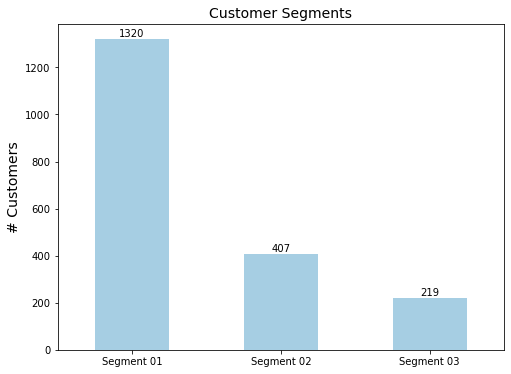

In [10]:
# K-Means Customer Segment Variable
from sklearn.cluster import KMeans                 # Customer segmentation
from sklearn.preprocessing import StandardScaler   # StandardScaler

# Instantiate scaler
scaler = StandardScaler()

# Subset for explanatory variables for customer segmentation EXCLUDING REVENUE
X = chefs.loc[:, chefs.columns[
    ~chefs.columns.isin([
        'REVENUE','log_REVENUE'])]].values

# Fit the scaler with our data for customer segmentation
scaler.fit(X)

# Fit the scaler with our data for customer segmentation
X_scaled = scaler.transform(X)

# Instantiate number of clusters
clusterNum = 3

# Instantiate KMEANS model
k_means = KMeans(init         = "k-means++", 
                 n_clusters   = clusterNum, 
                 n_init       = 12,
                 random_state = 219)

# Fit the model
k_means.fit(X_scaled)

# Grab each label (segmentation) for each customer
k_means_labels = k_means.labels_

# Add cluster labels to data set
chefs["KMEANS_CLUSTERS"] = k_means_labels

# Display cluster average per variable
#chefs.groupby('KMEANS_CLUSTERS').mean()

##############################################################################
# Plot 

# Count number of churn per month
genders = chefs['KMEANS_CLUSTERS'].value_counts()

# Create plot
ax = genders.plot(kind='bar', 
                  legend = True,
                  figsize = (8,6),
                  rot = 0,
                  colormap = "Paired")


# Annotate plot with values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 6),
                textcoords='offset points')

# Set plot aesthetics
ax.set_ylabel('# Customers',size = 14)
ax.set_xlabel('')
ax.set_title("Customer Segments", size = 14)
ax.set_xticklabels(labels = ['Segment 01', "Segment 02", "Segment 03"])
ax.legend().remove()
 
# Display plot
plt.show()
#plt.close()


##############################################################################
# Plot elbow point for optimal K

# Placeholder
#distortions = []

# Number of Ks
#K = range(1,10)

# Loop through each K
#for k in K:
#    kmeanModel = KMeans(n_clusters=k)
#    kmeanModel.fit(X)                            # Fit with X
#    distortions.append(kmeanModel.inertia_)      # Append inertia to distortions
    
# "Inertia can be recognized as a measure of how internally coherent clusters are."
# https://scikit-learn.org/stable/modules/clustering.html

# Plot elbow point
#plt.figure(figsize=(16,8))
#plt.plot(K, distortions, 'bx-')
#plt.xlabel('k')
#plt.ylabel('Distortion')
#plt.title('The Elbow Method showing the optimal k')
#plt.show()

# Source:
# https://predictivehacks.com/k-means-elbow-method-code-for-python/


##############################################################################
# Convert KMEANS_CLUSTERS into Dummy Variables

# Get dummy variables for KMEANS_CLUSTERS
one_hot_Clusters = pd.get_dummies(chefs['KMEANS_CLUSTERS'])

# Rename columns
one_hot_Clusters.columns = ['KMEANS_CLUSTER_0', 'KMEANS_CLUSTER_1', 'KMEANS_CLUSTER_2']

# Drop cluster 0 to follow n-1 
one_hot_Clusters.drop('KMEANS_CLUSTER_0', axis = 1, inplace = True)


# Drop KMEANS_CLUSTER 
chefs = chefs.drop('KMEANS_CLUSTERS', axis = 1)

# Join dummy variables back to Chefs dataframe
chefs = chefs.join([one_hot_Clusters])

In [11]:
# Export feature rich dataset to excel
#chefs.to_excel(excel_writer = './_data/Feature_Rich_Dataset.xlsx',
#                           index = False)

# Size of feature rich data
print(f"""
Size of Feature Rich Dataset
-----------------------------
Observations: {chefs.shape[0]}
Features:     {chefs.shape[1]}
""")


Size of Feature Rich Dataset
-----------------------------
Observations: 1946
Features:     64



In [12]:
# Identify variables with multicollinearity

# Create correlation dataframe
corr = chefs.corr()

# Unstack and make a dataframe
corr = pd.DataFrame(corr.unstack())

# Reset index to integers rather than variable 01
corr.reset_index(inplace = True)

# Rename columns
corr.columns = ["Var1", "Var2", "Corr"]

# Filter for variables with correlation of greater than 0.8
corr[(corr['Corr'] >= 0.8) & (corr['Corr'] < 1)]\
    .sort_values('Corr', ascending = False)\
    .drop_duplicates(subset=['Corr'])\
    .reset_index()

,index,Var1,Var2,Corr
0,1858,TOTAL_MEALS_DELIVERED,TOTAL_MEALS_ORDERED,0.999576
1,283,CONTACTS_W_CUSTOMER_SERVICE,log_CONTACTS_W_CUSTOMER_SERVICE,0.974019
2,1177,AVG_PREP_VID_TIME,log_AVG_PREP_VID_TIME,0.969869
3,540,CANCELLATIONS_BEFORE_NOON,TOTAL_CANCELS,0.963341
4,1387,MEDIAN_MEAL_RATING,MEAL_POLARITY,0.955776
5,24,REVENUE,log_REVENUE,0.947122
6,614,CANCELLATIONS_AFTER_NOON,LATE_CANCELLATION,0.938883
7,1321,MASTER_CLASSES_ATTENDED,LEARNER,0.902861
8,2533,CANCELED,EARLY_CANCELLATION,0.893464
9,2131,MEALS_PER_CLICK,AVG_MEALS_ORDERED,0.889273


# Models

## 1) Ordinary Least Squares (OLS)

In [13]:
# Run OLS model & print summary

# Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from regressors import stats


# Instantiate independant variables
X = chefs.loc[:, chefs.columns[
    ~chefs.columns.isin([
        
        # y-variables
        'REVENUE','log_REVENUE',        
    
        # multi-collinearity
        'TOTAL_MEALS_ORDERED',                        
        'MEDIAN_MEAL_RATING',           
        'CANCELLATIONS_BEFORE_NOON',    
        'CANCELLATIONS_AFTER_NOON',     
        'MASTER_CLASSES_ATTENDED',      
        'EARLY_CANCELLATION',           
        'EARLY_DELIVERIES',             
        'TOTAL_PHOTOS_VIEWED',     
        'AVG_MEALS_ORDERED',
        
        # log exclusions (3 total)
        'AVG_TIME_PER_SITE_VISIT',
        'AVG_PREP_VID_TIME',
        'CONTACTS_W_CUSTOMER_SERVICE',
    
        # high p-values
        'out_EARLY_DELIVERIES',
        'out_LATE_DELIVERIES',
        'WEEKLY_PLAN',
        'REFRIGERATED_LOCKER',
        'AVG_CLICKS_PER_VISIT',
        'LATE_DELIVERY',
        'PC_LOGINS',
        'PRODUCT_CATEGORIES_VIEWED',
        'MOBILE_NUMBER',
        'out_MEDIAN_MEAL_RATING',
        'VIEWED_PHOTOS',
        'EARLY_DELIVERY',
        'CANCELED',
        'DOMAIN_GROUP_PROFESSIONAL',
        'DOMAIN_GROUP_PERSONAL',
        'LATE_DELIVERIES',
        'GENDER',
        'out_WEEKLY_PLAN',
        'UNIQUE_MEALS_PURCH',
        'ORDERS_PER_PC_LOGIN',
        'out_AVG_MEALS_ORDERED',
        'ABOVE_AVG_CONTACT_W_CS',
        'TOTAL_MEALS_DELIVERED',
        'MOBILE_LOGINS'])]]            


# Instantiate dependant variable
y = chefs.loc[:, 'log_REVENUE']


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 219)


# Instantiate linear regression class
linear_regressor = LinearRegression()

# Fit the model
linear_regressor.fit(X_train, y_train)

# Predict log_revenue
ols_pred = linear_regressor.predict(X_test)

# Create a dataframe of variable coefficients
ols_coeff = pd.DataFrame(linear_regressor.coef_, X.columns, columns=['Coefficient'])

# Filter out coefficients that equal 0 and sort by descending
ols_coeff = ols_coeff[ols_coeff['Coefficient'] != 0]\
                .sort_values('Coefficient', ascending = False)

# Create a dataframe of actual vs predicted log_revenue
actual_vs_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': ols_pred})
#print(actual_vs_predicted)

# Scores
linear_train_score = abs(linear_regressor.score(X_train, y_train)).round(4) # using R-square
linear_test_score  = abs(linear_regressor.score(X_test, y_test)).round(4)   # using R-square
linear_test_gap    = abs(linear_train_score - linear_test_score).round(4)

##############################################################################
# Print model summary

# Instantiate list of used explarotary variable names
xlabels = chefs.columns[
    ~chefs.columns.isin([
        
        # y-variables
        'REVENUE','log_REVENUE',        
    
        # multi-collinearity
        'TOTAL_MEALS_ORDERED',                     
        'MEDIAN_MEAL_RATING',           
        'CANCELLATIONS_BEFORE_NOON',    
        'CANCELLATIONS_AFTER_NOON',     
        'MASTER_CLASSES_ATTENDED',      
        'EARLY_CANCELLATION',           
        'EARLY_DELIVERIES',             
        'TOTAL_PHOTOS_VIEWED',     
        'AVG_MEALS_ORDERED',
        
        # log exclusions (5 total)
        'AVG_TIME_PER_SITE_VISIT',
        'AVG_PREP_VID_TIME',
        'CONTACTS_W_CUSTOMER_SERVICE',
    
        # high p-values
        'out_EARLY_DELIVERIES',
        'out_LATE_DELIVERIES',
        'WEEKLY_PLAN',
        'REFRIGERATED_LOCKER',
        'AVG_CLICKS_PER_VISIT',
        'LATE_DELIVERY',
        'PC_LOGINS',
        'PRODUCT_CATEGORIES_VIEWED',
        'MOBILE_NUMBER',
        'out_MEDIAN_MEAL_RATING',
        'VIEWED_PHOTOS',
        'EARLY_DELIVERY',
        'CANCELED',
        'DOMAIN_GROUP_PROFESSIONAL',
        'DOMAIN_GROUP_PERSONAL',
        'LATE_DELIVERIES',
        'GENDER',
        'out_WEEKLY_PLAN',
        'UNIQUE_MEALS_PURCH',
        'ORDERS_PER_PC_LOGIN',
        'out_AVG_MEALS_ORDERED',
        'ABOVE_AVG_CONTACT_W_CS',
        'TOTAL_MEALS_DELIVERED',
        'MOBILE_LOGINS'])]

# Print model output:
print(f"""
=================== MODEL SUMMARY ===================


Model Type: Ordinary Least Squares (OLS)

Model Size: {len(xlabels) + 1}


---------------------------------


OLS Training Score : {linear_train_score}
OLS Testing Score  : {linear_test_score}
OLS Train-Test Gap : {linear_test_gap}


---------------------------------

""")

stats.summary(linear_regressor, X, y, xlabels)

# Code for SKLEARN p-values comes from:
# https://stackoverflow.com/questions/44495667/calculate-p-value-in-sklearn-using-python


=================== MODEL SUMMARY ===================


Model Type: Ordinary Least Squares (OLS)

Model Size: 28


---------------------------------


OLS Training Score : 0.7791
OLS Testing Score  : 0.7792
OLS Train-Test Gap : 0.0001


---------------------------------


Residuals:
    Min      1Q  Median      3Q     Max
-0.3696 -0.0593  0.0015  0.0545  0.7525


Coefficients:
                                 Estimate  Std. Error  t value   p value
_intercept                       2.034785    0.068255  29.8117  0.000000
CROSS_SELL_SUCCESS              -0.016975    0.004989  -3.4026  0.000681
TASTES_AND_PREFERENCES           0.009302    0.004952   1.8784  0.060478
PACKAGE_LOCKER                  -0.016102    0.004730  -3.4040  0.000678
log_AVG_PREP_VID_TIME            0.442173    0.020016  22.0911  0.000000
log_AVG_TIME_PER_SITE_VISIT     -0.020043    0.009702  -2.0658  0.038982
log_CONTACTS_W_CUSTOMER_SERVICE  0.296277    0.022571  13.1266  0.000000
TOTAL_CANCELS                    0.

## 2) Lasso

In [14]:
# Run LASSO model & print summary

# Libraries
from sklearn.linear_model import Lasso


# Instantiate independant variables
X = chefs.loc[:, chefs.columns[
    ~chefs.columns.isin([
        
        # y-variables
        'REVENUE','log_REVENUE',        
    
        # multi-collinearity
        'TOTAL_MEALS_ORDERED',                     
        'MEDIAN_MEAL_RATING',           
        'CANCELLATIONS_BEFORE_NOON',    
        'CANCELLATIONS_AFTER_NOON',     
        'MASTER_CLASSES_ATTENDED',      
        'EARLY_CANCELLATION',           
        'EARLY_DELIVERIES',             
        'TOTAL_PHOTOS_VIEWED',     
        'AVG_MEALS_ORDERED',
        
        # log exclusions
        'log_AVG_TIME_PER_SITE_VISIT',
        'log_AVG_PREP_VID_TIME',
        'log_CONTACTS_W_CUSTOMER_SERVICE'])]]          

# Instantiate dependant variable
y = chefs.loc[:, 'REVENUE']


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 219)


# Instantiate linear regression class
lasso_regressor = Lasso(max_iter = 100000)

# Fit the model
lasso_regressor.fit(X_train, y_train)

# Predict log_revenue
lasso_pred = lasso_regressor.predict(X_test)

# Create a dataframe of variable coefficients
lasso_coeff = pd.DataFrame(lasso_regressor.coef_, X.columns, columns=['Coefficient'])

# Filter out coefficients that equal 0 and sort by descending
lasso_coeff = lasso_coeff[lasso_coeff['Coefficient'] != 0]\
                .sort_values('Coefficient', ascending = False)


# Scores
lasso_train_score = abs(lasso_regressor.score(X_train, y_train)).round(4) # using R-square
lasso_test_score  = abs(lasso_regressor.score(X_test, y_test)).round(4)   # using R-square
lasso_test_gap    = abs(lasso_train_score - lasso_test_score).round(4)

##############################################################################
# Print model summary

print(f"""
=================== MODEL SUMMARY ===================


Model Type: Lasso

Model Size: {len(lasso_coeff) + 1}


---------------------------------


Lasso Training Score : {lasso_train_score}
Lasso Testing Score  : {lasso_test_score}
Lasso Train-Test Gap : {lasso_test_gap}


---------------------------------

Coefficients:
""")

print(lasso_coeff)


=================== MODEL SUMMARY ===================


Model Type: Lasso

Model Size: 48


---------------------------------


Lasso Training Score : 0.7414
Lasso Testing Score  : 0.7524
Lasso Train-Test Gap : 0.011


---------------------------------

Coefficients:

                                 Coefficient
KMEANS_CLUSTER_2                  726.629797
KMEANS_CLUSTER_1                  429.024039
MEAL_POLARITY                     275.455987
out_MEDIAN_MEAL_RATING            214.939224
out_MASTER_CLASSES_ATTENDED       159.240076
out_TOTAL_PHOTOS_VIEWED           158.445694
out_AVG_TIME_PER_SITE_VISIT       139.052006
LEARNER                           132.494120
out_AVG_PREP_VID_TIME             116.596746
CONTACTS_W_CUSTOMER_SERVICE        97.071188
out_CONTACTS_W_CUSTOMER_SERVICE    89.887946
out_AVG_CLICKS_PER_VISIT           80.951474
out_UNIQUE_MEALS_PURCH             76.373714
LATE_DELIVERY                      75.333229
LAST_NAME                          57.648274
out_PRODUC

## 3) Bayesian Automatic Relevance Determination (ARD)

In [15]:
# Run ARD model & print summary

# Libraries
from sklearn.linear_model import ARDRegression


# Instantiate independant variables
X = chefs.loc[:, chefs.columns[
    ~chefs.columns.isin([
        
        # y-variables
        'REVENUE','log_REVENUE',        
    
        # multi-collinearity
        'TOTAL_MEALS_ORDERED',                     
        'MEDIAN_MEAL_RATING',           
        'CANCELLATIONS_BEFORE_NOON',    
        'CANCELLATIONS_AFTER_NOON',     
        'MASTER_CLASSES_ATTENDED',      
        'EARLY_CANCELLATION',           
        'EARLY_DELIVERIES',             
        'TOTAL_PHOTOS_VIEWED',     
        'AVG_MEALS_ORDERED',
        
        # log exclusions
        'log_AVG_TIME_PER_SITE_VISIT',
        'log_AVG_PREP_VID_TIME',
        'log_CONTACTS_W_CUSTOMER_SERVICE'])]]      

# Instantiate dependant variable
y = chefs.loc[:, 'REVENUE']


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 219)


# Instantiate linear regression class
ard_regressor = ARDRegression()

# Fit the model
ard_regressor.fit(X_train, y_train)

# Predict log_revenue
ard_pred = ard_regressor.predict(X_test)

# Create a dataframe of variable coefficients
ard_coeff = pd.DataFrame(ard_regressor.coef_, X.columns, columns=['Coefficient'])

# Filter out coefficients that equal 0 and sort by descending
ard_coeff = ard_coeff[ard_coeff['Coefficient'] != 0]\
                .sort_values('Coefficient', ascending = False)

# Scores
ard_train_score = abs(ard_regressor.score(X_train, y_train)).round(4) # using R-square
ard_test_score  = abs(ard_regressor.score(X_test, y_test)).round(4)   # using R-square
ard_test_gap    = abs(ard_train_score - ard_test_score).round(4)

##############################################################################
# Print model summary

print(f"""
=================== MODEL SUMMARY ===================


Model Type: ARD

Model Size: {len(ard_coeff) + 1}


---------------------------------


ARD Training Score : {ard_train_score}
ARD Testing Score  : {ard_test_score}
ARD Train-Test Gap : {ard_test_gap}


---------------------------------

Coefficients:
""")

print(ard_coeff)


=================== MODEL SUMMARY ===================


Model Type: ARD

Model Size: 51


---------------------------------


ARD Training Score : 0.7397
ARD Testing Score  : 0.757
ARD Train-Test Gap : 0.0173


---------------------------------

Coefficients:

                                 Coefficient
KMEANS_CLUSTER_2                  858.646531
KMEANS_CLUSTER_1                  540.903008
MEAL_POLARITY                     297.238364
out_MEDIAN_MEAL_RATING            211.705265
out_TOTAL_PHOTOS_VIEWED           144.442943
out_MASTER_CLASSES_ATTENDED       143.758626
out_AVG_TIME_PER_SITE_VISIT       134.777807
LEARNER                           126.567156
out_AVG_PREP_VID_TIME             104.408702
CONTACTS_W_CUSTOMER_SERVICE       101.868595
out_AVG_CLICKS_PER_VISIT           86.409107
out_CONTACTS_W_CUSTOMER_SERVICE    84.393986
out_UNIQUE_MEALS_PURCH             76.857615
out_PRODUCT_CATEGORIES_VIEWED      45.213649
out_WEEKLY_PLAN                    37.409713
UNIQUE_MEALS_PURCH

## 4) K Nearest Neighbors

In [16]:
# Run KNN model & print summary

# Import model
from sklearn.neighbors import KNeighborsRegressor # KNN for Regression

##############################################################################
# Prepare data for model

# Instantiate independant variables
X = chefs.loc[:, chefs.columns[
    ~chefs.columns.isin([
        
        # y-variables
        'REVENUE','log_REVENUE',        
    
        # multi-collinearity
        'TOTAL_MEALS_ORDERED',                        
        'MEDIAN_MEAL_RATING',           
        'CANCELLATIONS_BEFORE_NOON',    
        'CANCELLATIONS_AFTER_NOON',     
        'MASTER_CLASSES_ATTENDED',      
        'EARLY_CANCELLATION',           
        'EARLY_DELIVERIES',             
        'TOTAL_PHOTOS_VIEWED',     
        'AVG_MEALS_ORDERED',
        
        # log exclusions (3 total)
        'AVG_TIME_PER_SITE_VISIT',
        'AVG_PREP_VID_TIME',
        'CONTACTS_W_CUSTOMER_SERVICE',
    
        # high p-values (carried from OLS)
        'out_EARLY_DELIVERIES',
        'out_LATE_DELIVERIES',
        'WEEKLY_PLAN',
        'REFRIGERATED_LOCKER',
        'AVG_CLICKS_PER_VISIT',
        'LATE_DELIVERY',
        'PC_LOGINS',
        'PRODUCT_CATEGORIES_VIEWED',
        'MOBILE_NUMBER',
        'out_MEDIAN_MEAL_RATING',
        'VIEWED_PHOTOS',
        'EARLY_DELIVERY',
        'CANCELED',
        'DOMAIN_GROUP_PROFESSIONAL',
        'DOMAIN_GROUP_PERSONAL',
        'LATE_DELIVERIES',
        'GENDER',
        'out_WEEKLY_PLAN',
        'UNIQUE_MEALS_PURCH',
        'ORDERS_PER_PC_LOGIN',
        'out_AVG_MEALS_ORDERED',
        'ABOVE_AVG_CONTACT_W_CS',
        'TOTAL_MEALS_DELIVERED',
        'MOBILE_LOGINS'])]]     

# Instantiate dependant variable
y = chefs.loc[:, 'log_REVENUE']

# Fit the scaler
scaler.fit(X)

# Transform the fitted scaler
X_scaled = scaler.transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size = 0.25, random_state = 219)


##############################################################################
# Check for optimal K

# creating lists for training set accuracy and test set accuracy
training_accuracy = []
test_accuracy     = []


# building a visualization of 1 to 50 neighbors
neighbors_settings = range(1, 21)


for n_neighbors in neighbors_settings:
    # Building the model
    clf = KNeighborsRegressor(n_neighbors = n_neighbors)
    clf.fit(X_train, y_train)
    
    # Recording the training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    
    # Recording the generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))


# plotting the visualization
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
#plt.show()
plt.close()


# finding the optimal number of neighbors
opt_neighbors = test_accuracy.index(max(test_accuracy)) + 1



##############################################################################
# Create model

# Instantiate a KNN model object
knn_reg = KNeighborsRegressor(algorithm = 'auto',
                              n_neighbors = opt_neighbors)


# Fit to the training data
knn_fit = knn_reg.fit(X_train, y_train)


# Predict on new data
knn_pred = knn_fit.predict(X_test)

# saving scoring data for future use
knn_train_score = knn_reg.score(X_train, y_train).round(4)
knn_test_score  = knn_reg.score(X_test, y_test).round(4)
knn_test_gap    = abs(knn_train_score - knn_test_score).round(4)


##############################################################################
# Print model summary

print(f"""
=================== MODEL SUMMARY ===================


Model Type: KNN

Model Size: NA


---------------------------------


KNN Training Score : {knn_train_score}
KNN Testing Score  : {knn_test_score}
KNN Train-Test Gap : {knn_test_gap}


---------------------------------
""")


=================== MODEL SUMMARY ===================


Model Type: KNN

Model Size: NA


---------------------------------


KNN Training Score : 0.7567
KNN Testing Score  : 0.7536
KNN Train-Test Gap : 0.0031


---------------------------------



## Predictions

In [17]:
# Consolidate predictions & deviations into a dataframe
prediction_results = pd.DataFrame(data = {
    'Original Revenue'     : (10**y_test),                                       # transform back to original
    'LR Predictions'       : (10**ols_pred).round(decimals = 2),                 # transform back to original
    'Lasso Predictions'    : lasso_pred.round(decimals = 2),
    'ARD Predictions'      : ard_pred.round(decimals = 2),
    'KNN Predictions'      : (10**knn_pred).round(decimals = 2),                 # transform back to original
    'LR Deviation'         : (10**ols_pred).round(decimals = 2) - (10**y_test),  # transform back to original
    'Lasso Deviation'      : lasso_pred.round(decimals = 2) - (10**y_test),      # transform back to original
    'ARD Deviation'        : ard_pred.round(decimals = 2) - (10**y_test),        # transform back to original
    'KNN Deviation'        : (10**knn_pred).round(decimals = 2) - (10**y_test)   # transform back to original
    })

# Export predictions
prediction_results.to_excel(excel_writer = './_model_results/model_predictions.xlsx',
                            index = False)

t1 = time.time()      # end time of script

#prediction_results

## Comparison & Final Model

In [18]:
# Model Comparison Summary

total_time = round(t1 - t0)      # compute time taken to run entire script


print(f"""
Model      Train Score      Test Score      Train-Test Gap        Model Size
-----      -----------      ----------      ---------------      -----------           
OLS        {linear_train_score}           {linear_test_score}          {linear_test_gap}               {len(xlabels)+1}
Lasso      {lasso_train_score}           {lasso_test_score}          {lasso_test_gap}                {len(lasso_coeff)+1}
ARD        {ard_train_score}           {ard_test_score}           {ard_test_gap}               {len(ard_coeff)+1}
KNN        {knn_train_score}           {knn_test_score}          {knn_test_gap}               NA


=======================================================================================================

OLS is the final model with a test score of {linear_test_score}, a train-test gap of {linear_test_gap}, and a model size of {len(xlabels)+1}.

=======================================================================================================


OLS Coefficients:

{ols_coeff}


Interested in coefficients of other models? Please scroll up to the output of that respective model.

Total run time of script: {total_time} seconds.
""")

# Create dictionary for model results
model_performance = {
    
    'Model Type'    : ['OLS', 'Lasso', 'ARD', 'KNN'],
           
    'Training' : [linear_train_score, lasso_train_score, 
                  ard_train_score, knn_train_score],
           
    'Testing'  : [linear_test_score, lasso_test_score, 
                  ard_test_score, knn_test_score],
                    
    'Train-Test Gap' : [linear_test_gap, lasso_test_gap, 
                        ard_test_gap, knn_test_gap],
                    
    'Model Size' : [len(xlabels)+1, len(lasso_coeff)+1,
                                    len(ard_coeff)+1, 'NA']}


# Convert model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)


# Export model results to excel
#model_performance.to_excel('./_model_results/model_performance.xlsx',
#                           index = False)


Model      Train Score      Test Score      Train-Test Gap        Model Size
-----      -----------      ----------      ---------------      -----------           
OLS        0.7791           0.7792          0.0001               28
Lasso      0.7414           0.7524          0.011                48
ARD        0.7397           0.757           0.0173               51
KNN        0.7567           0.7536          0.0031               NA



OLS is the final model with a test score of 0.7792, a train-test gap of 0.0001, and a model size of 28.



OLS Coefficients:

                                 Coefficient
log_AVG_PREP_VID_TIME               0.442173
log_CONTACTS_W_CUSTOMER_SERVICE     0.296277
KMEANS_CLUSTER_2                    0.147244
KMEANS_CLUSTER_1                    0.085087
MEAL_POLARITY                       0.073388
out_UNIQUE_MEALS_PURCH              0.028972
LEARNER                             0.025523
out_CONTACTS_W_CUSTOMER_SERVICE     0.023797
out_AVG_TIME_PER_SITE_VISIT 